In [2]:
# 本文使用词袋模型（Bag of Words）训练一个文本分类器，训练集来自IMDB影评
from pathlib import Path

import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from google_drive_downloader import GoogleDriveDownloader as gdd
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm, tqdm_notebook

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
# 下载数据集 也可网页访问 https://drive.google.com/file/d/1zfM5E6HvKIe7f3rEt1V2gBpw5QOSSKQz/view 下载
# 注意gdd需要外网连接才能下载，这里我提前将数据集下好放入对应路径
DATA_PATH = 'data/imdb_reviews.csv'
if not Path(DATA_PATH).is_file():
    gdd.download_file_from_google_drive(
        file_id='1zfM5E6HvKIe7f3rEt1V2gBpw5QOSSKQz',
        dest_path=DATA_PATH,
    )

In [6]:
# 从下好的数据集挑一些例子查看
pd.read_csv(DATA_PATH).sample(5)

,review,label
56402,This is a very strange film by director/animat...,1
61803,I was very disappointed in this movie. Plotwis...,0
27386,Loony Tunes have ventured (at least) twice int...,0
56245,This film was really bad whether you take it a...,0
5489,It hasn't even been two years since I first sa...,0


## 词袋模型就是从语料库中建立词典，然后为每一句话生成一个向量，向量长度为词典长度，涉及到的单词就将其对应位加1，即重复单词会>1
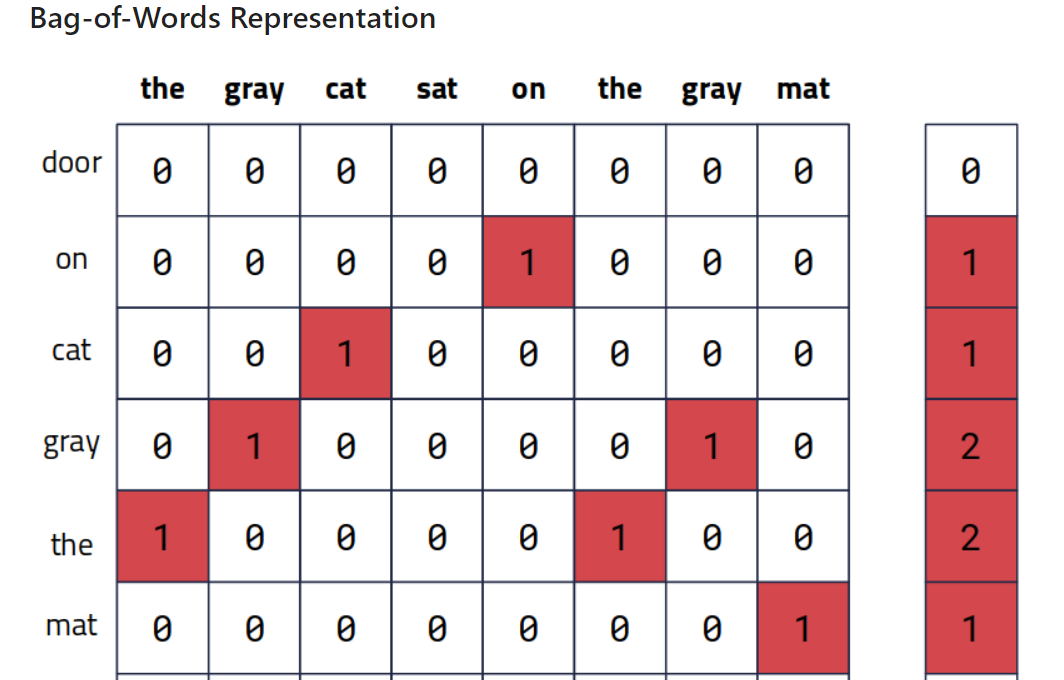
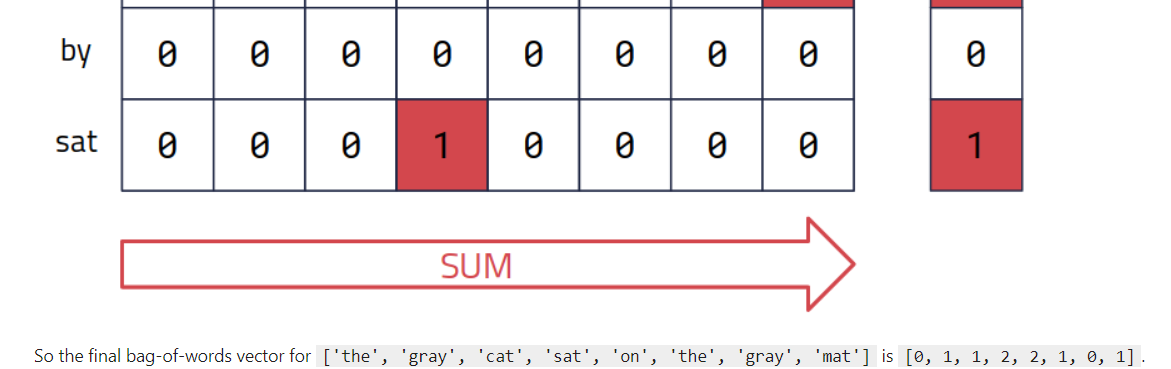

## CountVectorizer实现词袋模型例子
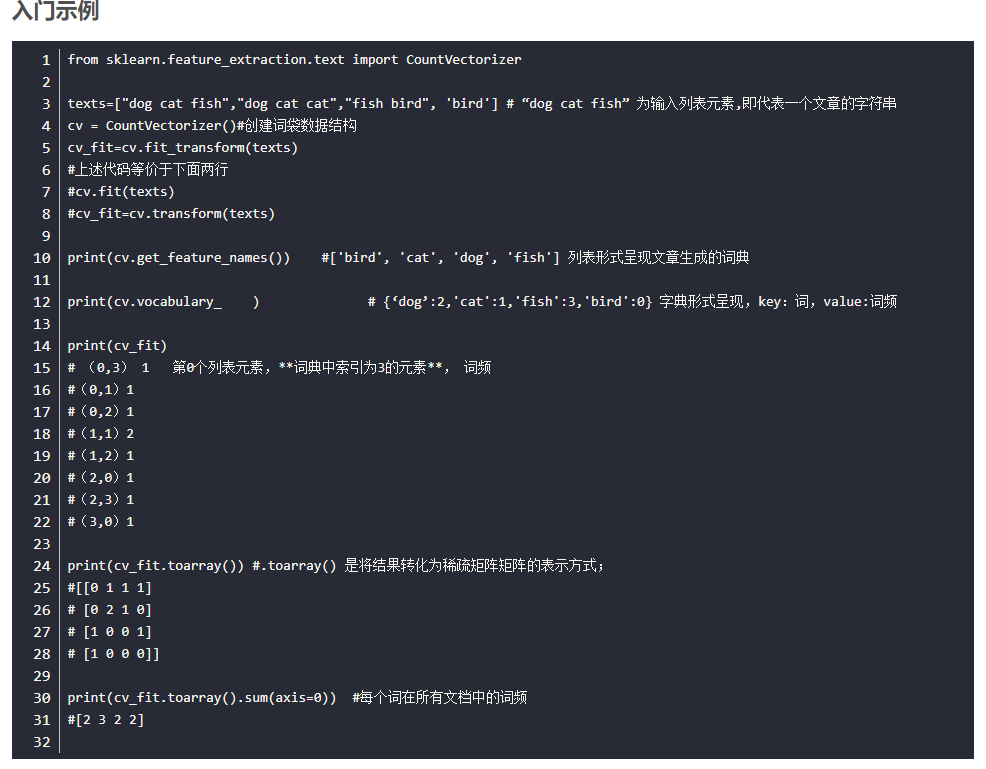

In [7]:
# 词袋模型类
class Sequences(Dataset):
    def __init__(self, path):
        df = pd.read_csv(path)
        # CountVectorizer 详解来自 https://blog.csdn.net/weixin_38278334/article/details/82320307
        self.vectorizer = CountVectorizer(stop_words='english', max_df=0.99, min_df=0.005) # 设定停用词和词频的上下限
        self.sequences = self.vectorizer.fit_transform(df.review.tolist())
        self.labels = df.label.tolist()
        self.token2idx = self.vectorizer.vocabulary_
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}
        
    def __getitem__(self, i):
        return self.sequences[i, :].toarray(), self.labels[i]
    
    def __len__(self):
        return self.sequences.shape[0]

In [8]:
dataset = Sequences(DATA_PATH)
train_loader = DataLoader(dataset, batch_size=4096)

print(dataset[5][0].shape)

(1, 3028)


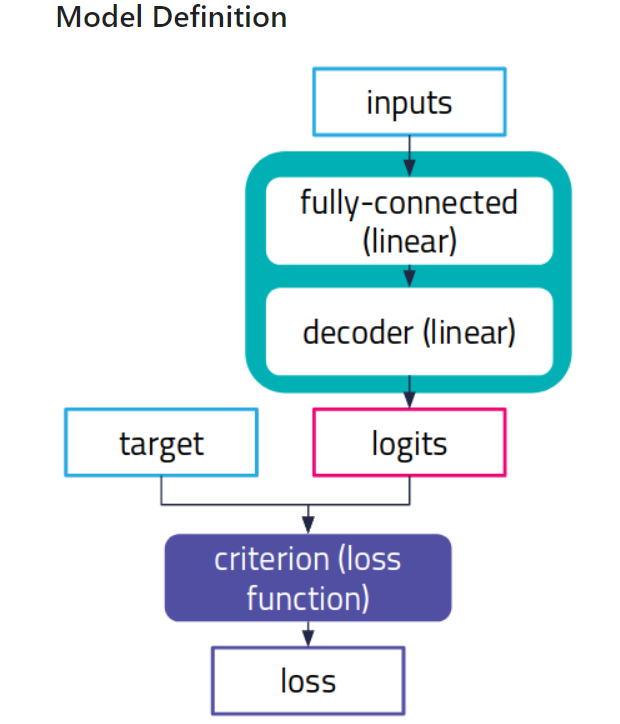

In [12]:
# 定义模型 三层全连接层
class BagOfWordsClassifier(nn.Module):
    def __init__(self, vocab_size, hidden1, hidden2):
        super(BagOfWordsClassifier, self).__init__()
        self.fc1 = nn.Linear(vocab_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, 1)
        
    def forward(self, inputs):
        x = F.relu(self.fc1(inputs.squeeze(1).float()))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [13]:
model = BagOfWordsClassifier(len(dataset.token2idx), 128, 64)
model

BagOfWordsClassifier(
  (fc1): Linear(in_features=3028, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [14]:
# BCEWithLogitsLoss自带sigmoid
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.001)

In [15]:
# 有dropout层，需要设置到训练模式
model.train()
train_losses = []
for epoch in range(10):
    progress_bar = tqdm_notebook(train_loader, leave=False)
    losses = []
    total = 0
    for inputs, target in progress_bar:
        model.zero_grad()

        output = model(inputs)
        loss = criterion(output.squeeze(), target.float())
        
        loss.backward()
        
        # 梯度裁剪 类似dropout
        nn.utils.clip_grad_norm_(model.parameters(), 3)

        optimizer.step()
        
        progress_bar.set_description(f'Loss: {loss.item():.3f}')
        
        losses.append(loss.item())
        total += 1
    
    epoch_loss = sum(losses) / total
    train_losses.append(epoch_loss)
        
    tqdm.write(f'Epoch #{epoch + 1}\tTrain Loss: {epoch_loss:.3f}')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


Epoch #1	Train Loss: 0.713


Epoch #2	Train Loss: 0.681


Epoch #3	Train Loss: 0.657


Epoch #4	Train Loss: 0.602


Epoch #5	Train Loss: 0.522


Epoch #6	Train Loss: 0.442


Epoch #7	Train Loss: 0.381


Epoch #8	Train Loss: 0.342


Epoch #9	Train Loss: 0.317


Epoch #10	Train Loss: 0.300


In [16]:
def predict_sentiment(text):
    # 预测时不需要dropout相关特殊层，设置到预测模式
    model.eval()
    with torch.no_grad():
        test_vector = torch.LongTensor(dataset.vectorizer.transform([text]).toarray())
        
        output = model(test_vector)
        prediction = torch.sigmoid(output).item()
        
        if prediction > 0.5:
            print(f'{prediction:0.3}: Positive sentiment')
        else:
            print(f'{prediction:0.3}: Negative sentiment')

In [17]:
# 实例预测
test_text = """
This poor excuse for a movie is terrible. It has been 'so good it's bad' for a
while, and the high ratings are a good form of sarcasm, I have to admit. But
now it has to stop. Technically inept, spoon-feeding mundane messages with the
artistic weight of an eighties' commercial, hypocritical to say the least, it
deserves to fall into oblivion. Mr. Derek, I hope you realize you are like that
weird friend that everybody know is lame, but out of kindness and Christian
duty is treated like he's cool or something. That works if you are a good
decent human being, not if you are a horrible arrogant bully like you are. Yes,
Mr. 'Daddy' Derek will end on the history books of the internet for being a
delusional sour old man who thinks to be a good example for kids, but actually
has a poster of Kim Jong-Un in his closet. Destroy this movie if you all have a
conscience, as I hope IHE and all other youtube channel force-closed by Derek
out of SPITE would destroy him in the courts.This poor excuse for a movie is
terrible. It has been 'so good it's bad' for a while, and the high ratings are
a good form of sarcasm, I have to admit. But now it has to stop. Technically
inept, spoon-feeding mundane messages with the artistic weight of an eighties'
commercial, hypocritical to say the least, it deserves to fall into oblivion.
Mr. Derek, I hope you realize you are like that weird friend that everybody
know is lame, but out of kindness and Christian duty is treated like he's cool
or something. That works if you are a good decent human being, not if you are a
horrible arrogant bully like you are. Yes, Mr. 'Daddy' Derek will end on the
history books of the internet for being a delusional sour old man who thinks to
be a good example for kids, but actually has a poster of Kim Jong-Un in his
closet. Destroy this movie if you all have a conscience, as I hope IHE and all
other youtube channel force-closed by Derek out of SPITE would destroy him in
the courts.
"""
predict_sentiment(test_text)

0.00147: Negative sentiment


In [18]:
test_text = """
Cool Cat Saves The Kids is a symbolic masterpiece directed by Derek Savage that
is not only satirical in the way it makes fun of the media and politics, but in
the way in questions as how we humans live life and how society tells us to
live life.

Before I get into those details, I wanna talk about the special effects in this
film. They are ASTONISHING, and it shocks me that Cool Cat Saves The Kids got
snubbed by the Oscars for Best Special Effects. This film makes 2001 look like
garbage, and the directing in this film makes Stanley Kubrick look like the
worst director ever. You know what other film did that? Birdemic: Shock and
Terror. Both of these films are masterpieces, but if I had to choose my
favorite out of the 2, I would have to go with Cool Cat Saves The Kids. It is
now my 10th favorite film of all time.

Now, lets get into the symbolism: So you might be asking yourself, Why is Cool
Cat Orange? Well, I can easily explain. Orange is a color. Orange is also a
fruit, and its a very good fruit. You know what else is good? Good behavior.
What behavior does Cool Cat have? He has good behavior. This cannot be a
coincidence, since cool cat has good behavior in the film.

Now, why is Butch The Bully fat? Well, fat means your wide. You wanna know who
was wide? Hitler. Nuff said this cannot be a coincidence.

Why does Erik Estrada suspect Butch The Bully to be a bully? Well look at it
this way. What color of a shirt was Butchy wearing when he walks into the area?
I don't know, its looks like dark purple/dark blue. Why rhymes with dark? Mark.
Mark is that guy from the Room. The Room is the best movie of all time. What is
the opposite of best? Worst. This is how Erik knew Butch was a bully.

and finally, how come Vivica A. Fox isn't having a successful career after
making Kill Bill.

I actually can't answer that question.

Well thanks for reading my review.
"""
predict_sentiment(test_text)

0.932: Positive sentiment
